In this notebook, we built several models with 'app_train_domain.csv'.

The classification algorithms used are Logistic Regression, Random Forest Classifier, LGBM Classifier and XGB Classifier.

To solve the problem of imbalanced data, we tested 3 methods:
- RandomUnderSampling
- RandomOverSampling
- SMOTE

In this notebook, we have not applied cross validation to speed up the process.

For each model, AUC was calculated for test and training sets, precision and recall for test set. The confusion matrix and graphs showing the most important variables were also displayed.

Remark: RandomForestClassifier overfit (AUC for training set equal to 1 and AUC for test set is not as great).

# 1. Imports

In [1]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer
from imblearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
import re

# 2. Load Data

In [2]:
app_train_domain = pd.read_csv('app_train_domain.csv')

In [3]:
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

In [4]:
sns.set_theme(style='darkgrid')

# 3. Model

In [5]:
train = app_train_domain.copy()

In [6]:
# Extract the ids
train_ids = train['SK_ID_CURR']
    
# Extract the labels for training
labels = train['TARGET']
    
# Remove the ids and target
train = train.drop(columns = ['SK_ID_CURR', 'TARGET'])

In [7]:
categorical_features_1 = []
categorical_features_2 = []

for col in train.select_dtypes(['object', 'bool']):
    if len(list(train[col].unique())) <= 2:
        categorical_features_1.append(col)
    else:
        categorical_features_2.append(col)

In [8]:
numerical_features = train.select_dtypes(['float64', 'int64']).columns.tolist()

In [9]:
numerical_pipeline = make_pipeline(SimpleImputer(strategy='median'), MinMaxScaler(feature_range=(0, 1)))
categorical_pipeline_1 = make_pipeline(SimpleImputer(strategy='constant', fill_value='Missing'), OrdinalEncoder())
categorical_pipeline_2 = make_pipeline(SimpleImputer(strategy='constant', fill_value='Missing'), OneHotEncoder(handle_unknown='ignore'))

In [10]:
preprocessor = make_column_transformer((numerical_pipeline, numerical_features), (categorical_pipeline_1, categorical_features_1), (categorical_pipeline_2, categorical_features_2))

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(train, labels, test_size=0.20, random_state=42)

In [12]:
def conf_matrix(y_test, pred):
    con_mat = confusion_matrix(y_test, pred)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
    plt.figure(figsize=(4, 4))
    plt.title('Confusion Matrix', size=15)
    sns.heatmap(con_mat, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

In [13]:
def get_column_names_from_ColumnTransformer(column_transformer):
    """
    Helper function which explores a Column Transformer to get feature names
    Parameters
    ----------
    column_transformer: a sklearn column_transformer
    Returns
    ----------
    a list of strings of the column names of the outputs of the colun_transformer
    """
    col_name = []
    for transformer_in_columns in column_transformer.transformers_:
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1], Pipeline):
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        if isinstance(transformer, OneHotEncoder):
            if isinstance(raw_col_name, str):
                names = transformer.get_feature_names(input_features=[raw_col_name])
            else:
                names = transformer.get_feature_names(input_features=raw_col_name)
        elif isinstance(transformer, PolynomialFeatures):
            names = transformer.get_feature_names(input_features=raw_col_name)
        else:
            try:
                names = transformer.get_feature_names()
            except AttributeError:
                # if no 'get_feature_names' function, use raw column name
                names = raw_col_name
        if isinstance(names, np.ndarray):  # eg.
            col_name += names.tolist()
        elif isinstance(names, list):
            col_name += names
        elif isinstance(names, str):
            col_name.append(names)
    return col_name

### 3.1. Logistic Regression

#### With Under Sampling

In [14]:
rus = RandomUnderSampler(random_state=42)
X_train_rus, Y_train_rus = rus.fit_resample(X_train, Y_train)

In [15]:
model_lr = make_pipeline(preprocessor, SelectFromModel(XGBClassifier()), LogisticRegression(random_state=42))

In [16]:
model_lr.fit(X_train_rus, Y_train_rus)
pred_1 = model_lr.predict_proba(X_test)
pred_1 = pred_1[:, 1]

[14:42:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [17]:
auc_1 = roc_auc_score(Y_test, pred_1)
print('AUC: ', auc_1)

AUC:  0.7495327825662119


In [18]:
pred_1_t = model_lr.predict_proba(X_train_rus)
pred_1_t = pred_1_t[:, 1]
auc_1_t = roc_auc_score(Y_train_rus, pred_1_t)
print('AUC: ', auc_1_t)

AUC:  0.7494244148698789


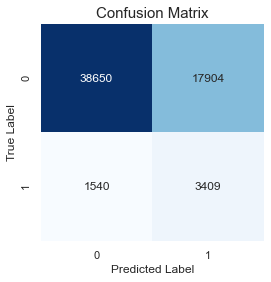

In [19]:
pred_test = model_lr.predict(X_test)
conf_matrix(Y_test, pred_test)

In [20]:
precision_1 = precision_score(Y_test, pred_test)
recall_1 = recall_score(Y_test, pred_test)

print('precision: ', precision_1)
print('recall: ', recall_1)

precision:  0.15994932670201287
recall:  0.6888260254596889


In [21]:
mask = model_lr['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(model_lr['columntransformer'])):
    if bool:
        new_features.append(feature)

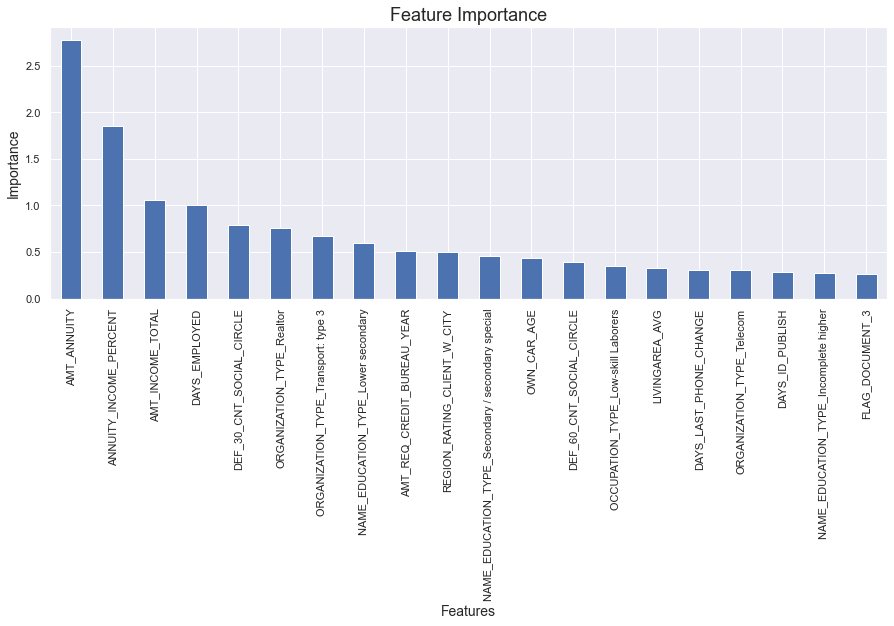

In [22]:
Importance = pd.DataFrame(model_lr['logisticregression'].coef_[0], index = new_features, columns = ['Importance'])
plt.figure(figsize = (15,5))
Importance['Importance'].sort_values(ascending = False)[:20].plot.bar(y = 'Importance')
plt.title('Feature Importance', fontsize = 18)
plt.xlabel('Features', size = 14)
plt.ylabel('Importance', size = 14)
plt.show()

#### With Over Sampling

In [23]:
ros = RandomOverSampler(random_state=42)
X_train_ros, Y_train_ros = ros.fit_resample(X_train, Y_train)

In [24]:
model_lr = make_pipeline(preprocessor, SelectFromModel(XGBClassifier()), LogisticRegression(random_state=42))

In [25]:
model_lr.fit(X_train_ros, Y_train_ros)
pred_2 = model_lr.predict_proba(X_test)
pred_2 = pred_2[:, 1]

[14:42:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [26]:
auc_2 = roc_auc_score(Y_test, pred_2)
print('AUC: ', auc_2)

AUC:  0.7497938712463049


In [27]:
pred_2_t = model_lr.predict_proba(X_train_ros)
pred_2_t = pred_2_t[:, 1]
auc_2_t = roc_auc_score(Y_train_ros, pred_2_t)
print('AUC: ', auc_2_t)

AUC:  0.7498870335577988


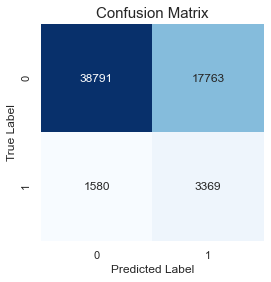

In [28]:
pred_test = model_lr.predict(X_test)
conf_matrix(Y_test, pred_test)

In [29]:
precision_2 = precision_score(Y_test, pred_test)
recall_2 = recall_score(Y_test, pred_test)

print('precision: ', precision_2)
print('recall: ', recall_2)

precision:  0.15942646223736515
recall:  0.6807435845625379


In [30]:
mask = model_lr['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(model_lr['columntransformer'])):
    if bool:
        new_features.append(feature)

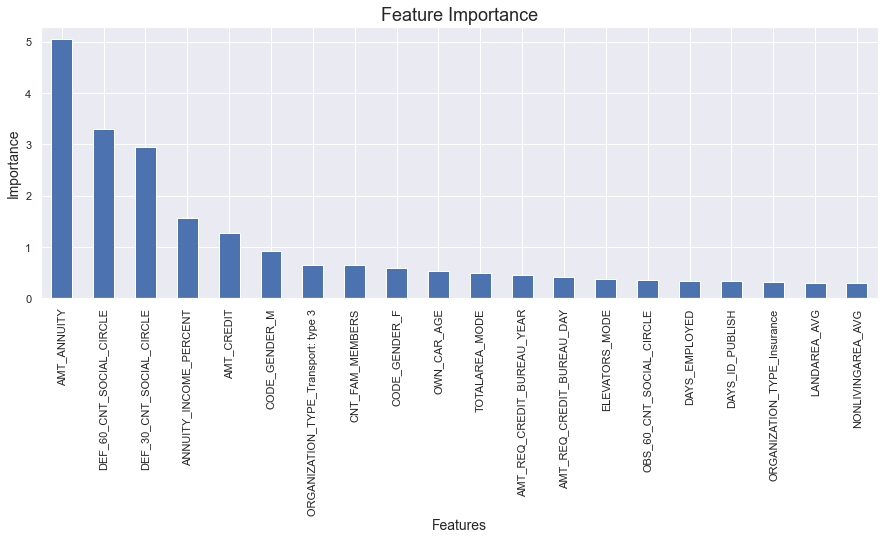

In [31]:
Importance = pd.DataFrame(model_lr['logisticregression'].coef_[0], index = new_features, columns = ['Importance'])
plt.figure(figsize = (15,5))
Importance['Importance'].sort_values(ascending = False)[:20].plot.bar(y = 'Importance')
plt.title('Feature Importance', fontsize = 18)
plt.xlabel('Features', size = 14)
plt.ylabel('Importance', size = 14)
plt.show()

#### With SMOTE

In [32]:
X_train_smo = preprocessor.fit_transform(X_train)
X_test_smo = preprocessor.fit_transform(X_test)

In [33]:
X_train_smo = pd.DataFrame(X_train_smo, columns=get_column_names_from_ColumnTransformer(preprocessor))
X_test_smo = pd.DataFrame(X_test_smo, columns=get_column_names_from_ColumnTransformer(preprocessor))

In [34]:
smo = SMOTE(random_state=42)
X_train_smo, Y_train_smo = smo.fit_resample(X_train_smo, Y_train)

In [35]:
model_lr = make_pipeline(SelectFromModel(XGBClassifier()), LogisticRegression(random_state=42))

In [36]:
model_lr.fit(X_train_smo, Y_train_smo)
pred_3 = model_lr.predict_proba(X_test_smo)
pred_3 = pred_3[:, 1]

[14:44:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [37]:
auc_3 = roc_auc_score(Y_test, pred_3)
print('AUC: ', auc_3)

AUC:  0.729186891139501


In [38]:
pred_3_t = model_lr.predict_proba(X_train_smo)
pred_3_t = pred_3_t[:, 1]
auc_3_t = roc_auc_score(Y_train_smo, pred_3_t)
print('AUC: ', auc_3_t)

AUC:  0.766751227286823


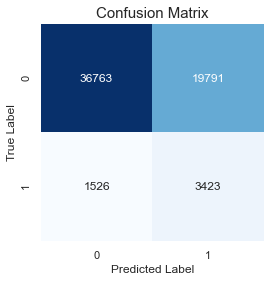

In [39]:
pred_test = model_lr.predict(X_test_smo)
conf_matrix(Y_test, pred_test)

In [40]:
precision_3 = precision_score(Y_test, pred_test)
recall_3 = recall_score(Y_test, pred_test)

print('precision: ', precision_3)
print('recall: ', recall_3)

precision:  0.14745412251227707
recall:  0.6916548797736917


In [41]:
mask = model_lr['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(preprocessor)):
    if bool:
        new_features.append(feature)

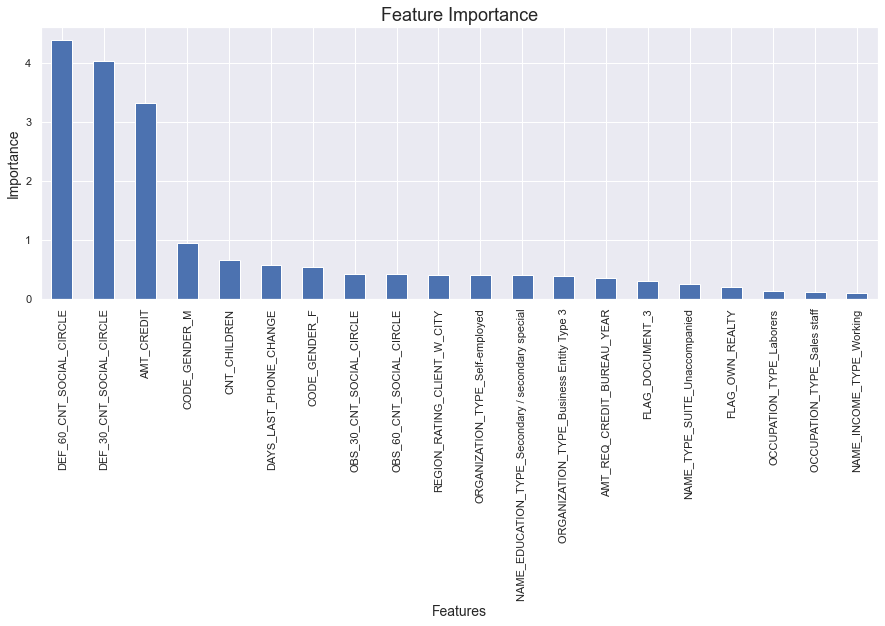

In [42]:
Importance = pd.DataFrame(model_lr['logisticregression'].coef_[0], index=new_features, columns=['Importance'])
plt.figure(figsize=(15, 5))
Importance['Importance'].sort_values(ascending=False)[:20].plot.bar(y='Importance')
plt.title('Feature Importance', fontsize=18)
plt.xlabel('Features', size=14)
plt.ylabel('Importance', size=14)
plt.show()

### 3.2. Random Forest Classifier

#### With Under Sampling

In [43]:
model_rfc = make_pipeline(preprocessor, SelectFromModel(XGBClassifier()), RandomForestClassifier(random_state=42))

In [44]:
model_rfc.fit(X_train_rus, Y_train_rus)
pred_4 = model_rfc.predict_proba(X_test)
pred_4 = pred_4[:, 1]

[14:47:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [45]:
auc_4 = roc_auc_score(Y_test, pred_4)
print('AUC: ', auc_4)

AUC:  0.7366215141231236


In [46]:
pred_4_t = model_rfc.predict_proba(X_train_rus)
pred_4_t = pred_4_t[:, 1]
auc_4_t = roc_auc_score(Y_train_rus, pred_4_t)
print('AUC: ', auc_4_t)

AUC:  1.0


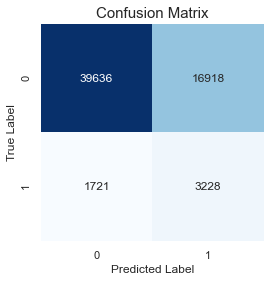

In [47]:
pred_test = model_rfc.predict(X_test)
conf_matrix(Y_test, pred_test)

In [48]:
precision_4 = precision_score(Y_test, pred_test)
recall_4 = recall_score(Y_test, pred_test)

print('precision: ', precision_4)
print('recall: ', recall_4)

precision:  0.16023031867368212
recall:  0.6522529804000808


In [49]:
mask = model_rfc['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(model_rfc['columntransformer'])):
    if bool:
        new_features.append(feature)

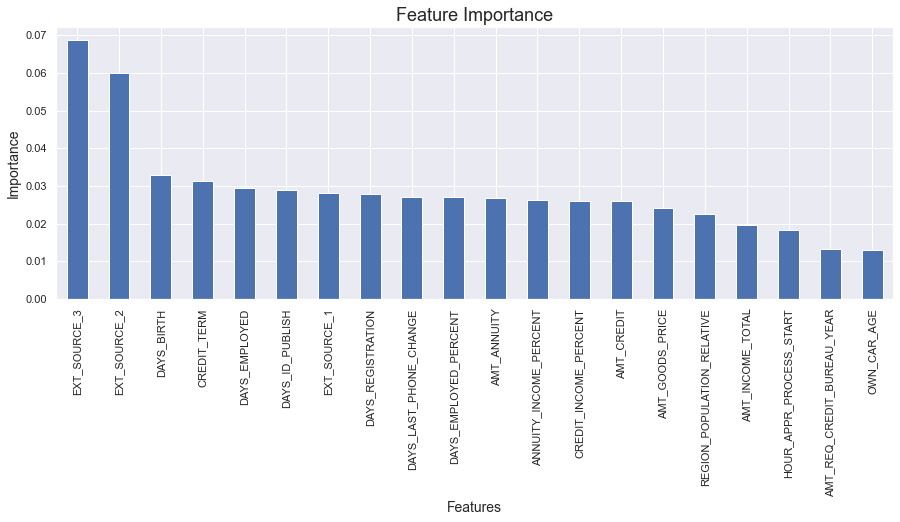

In [50]:
Importance = pd.DataFrame(model_rfc['randomforestclassifier'].feature_importances_, index = new_features, columns = ['Importance'])
plt.figure(figsize=(15, 5))
Importance['Importance'].sort_values(ascending = False)[:20].plot.bar(y = 'Importance')
plt.title('Feature Importance', fontsize = 18)
plt.xlabel('Features', size = 14)
plt.ylabel('Importance', size = 14)
plt.show()

#### With Over Sampling

In [51]:
model_rfc = make_pipeline(preprocessor, SelectFromModel(XGBClassifier()), RandomForestClassifier(random_state=42))

In [52]:
model_rfc.fit(X_train_ros, Y_train_ros)
pred_5 = model_rfc.predict_proba(X_test)
pred_5 = pred_5[:, 1]

[14:47:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [53]:
auc_5 = roc_auc_score(Y_test, pred_5)
print('AUC: ', auc_5)

AUC:  0.7324464354822843


In [54]:
pred_5_t = model_rfc.predict_proba(X_train_ros)
pred_5_t = pred_5_t[:, 1]
auc_5_t = roc_auc_score(Y_train_ros, pred_5_t)
print('AUC: ', auc_5_t)

AUC:  1.0


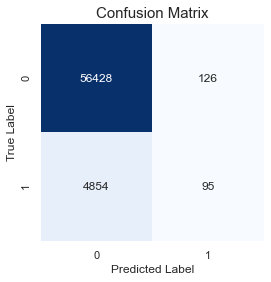

In [55]:
pred_test = model_rfc.predict(X_test)
conf_matrix(Y_test, pred_test)

In [56]:
precision_5 = precision_score(Y_test, pred_test)
recall_5 = recall_score(Y_test, pred_test)

print('precision: ', precision_5)
print('recall: ', recall_5)

precision:  0.4298642533936652
recall:  0.01919579713073348


In [57]:
mask = model_rfc['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(model_rfc['columntransformer'])):
    if bool:
        new_features.append(feature)

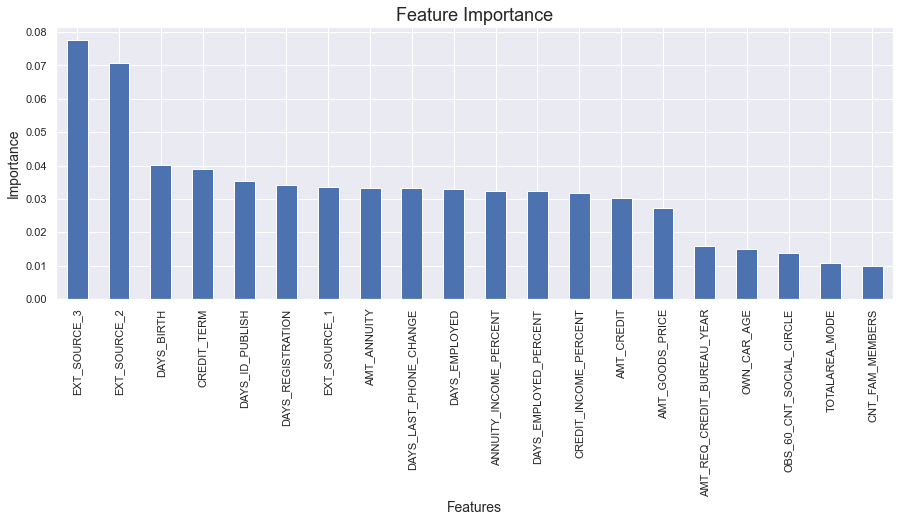

In [58]:
Importance = pd.DataFrame(model_rfc['randomforestclassifier'].feature_importances_, index = new_features, columns = ['Importance'])
plt.figure(figsize=(15, 5))
Importance['Importance'].sort_values(ascending = False)[:20].plot.bar(y = 'Importance')
plt.title('Feature Importance', fontsize = 18)
plt.xlabel('Features', size = 14)
plt.ylabel('Importance', size = 14)
plt.show()

#### With SMOTE

In [59]:
model_rfc = make_pipeline(SelectFromModel(XGBClassifier()), RandomForestClassifier(random_state=42))

In [60]:
model_rfc.fit(X_train_smo, Y_train_smo)
pred_6 = model_rfc.predict_proba(X_test_smo)
pred_6 = pred_6[:, 1]

[14:51:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [61]:
auc_6 = roc_auc_score(Y_test, pred_6)
print('AUC: ', auc_6)

AUC:  0.6799781829546974


In [62]:
pred_6_t = model_rfc.predict_proba(X_train_smo)
pred_6_t = pred_6_t[:, 1]
auc_6_t = roc_auc_score(Y_train_smo, pred_6_t)
print('AUC: ', auc_6_t)

AUC:  1.0


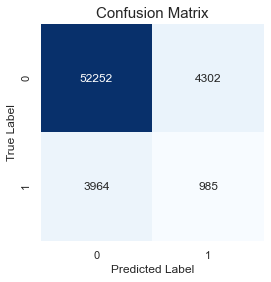

In [63]:
pred_test = model_rfc.predict(X_test_smo)
conf_matrix(Y_test, pred_test)

In [64]:
precision_6 = precision_score(Y_test, pred_test)
recall_6 = recall_score(Y_test, pred_test)

print('precision: ', precision_6)
print('recall: ', recall_6)

precision:  0.1863060336674863
recall:  0.1990301070923419


In [65]:
mask = model_rfc['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(preprocessor)):
    if bool:
        new_features.append(feature)

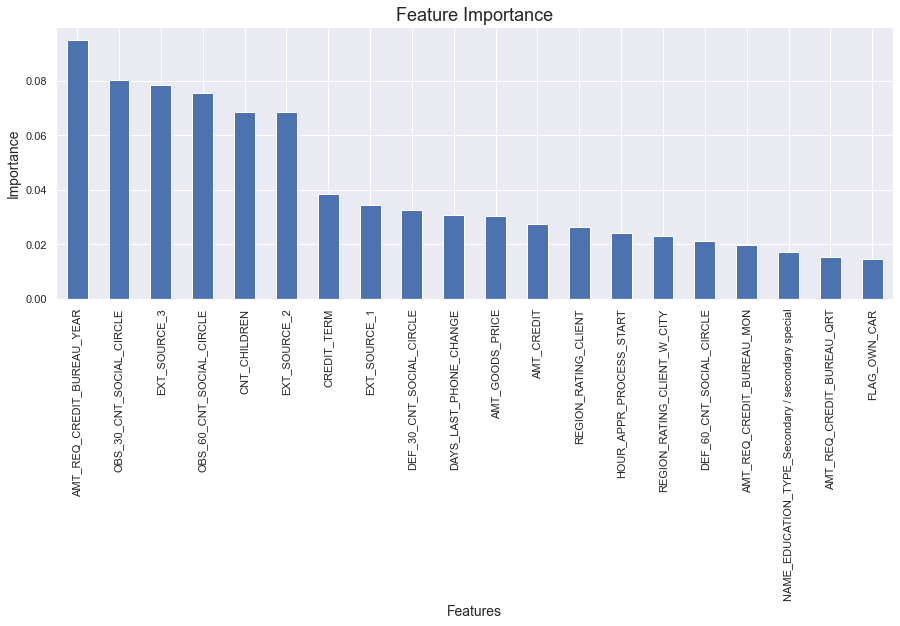

In [66]:
Importance = pd.DataFrame(model_rfc['randomforestclassifier'].feature_importances_, index = new_features, columns = ['Importance'])
plt.figure(figsize=(15, 5))
Importance['Importance'].sort_values(ascending = False)[:20].plot.bar(y = 'Importance')
plt.title('Feature Importance', fontsize = 18)
plt.xlabel('Features', size = 14)
plt.ylabel('Importance', size = 14)
plt.show()

### 3.3. LGBMClassifier

#### With Under Sampling

In [67]:
model_lgbmc = make_pipeline(preprocessor, SelectFromModel(XGBClassifier()), LGBMClassifier(random_state=42))

In [68]:
model_lgbmc.fit(X_train_rus, Y_train_rus)
pred_7 = model_lgbmc.predict_proba(X_test)
pred_7 = pred_7[:, 1]

[14:55:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [69]:
auc_7 = roc_auc_score(Y_test, pred_7)
print('AUC: ', auc_7)

AUC:  0.7622089014851082


In [70]:
pred_7_t = model_lgbmc.predict_proba(X_train_rus)
pred_7_t = pred_7_t[:, 1]
auc_7_t = roc_auc_score(Y_train_rus, pred_7_t)
print('AUC: ', auc_7_t)

AUC:  0.8235931511535739


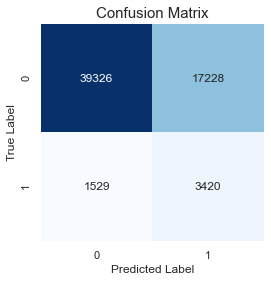

In [71]:
pred_test = model_lgbmc.predict(X_test)
conf_matrix(Y_test, pred_test)

In [72]:
precision_7 = precision_score(Y_test, pred_test)
recall_7 = recall_score(Y_test, pred_test)

print('precision: ', precision_7)
print('recall: ', recall_7)

precision:  0.16563347539713288
recall:  0.6910486967064053


In [73]:
mask = model_lgbmc['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(model_lgbmc['columntransformer'])):
    if bool:
        new_features.append(feature)

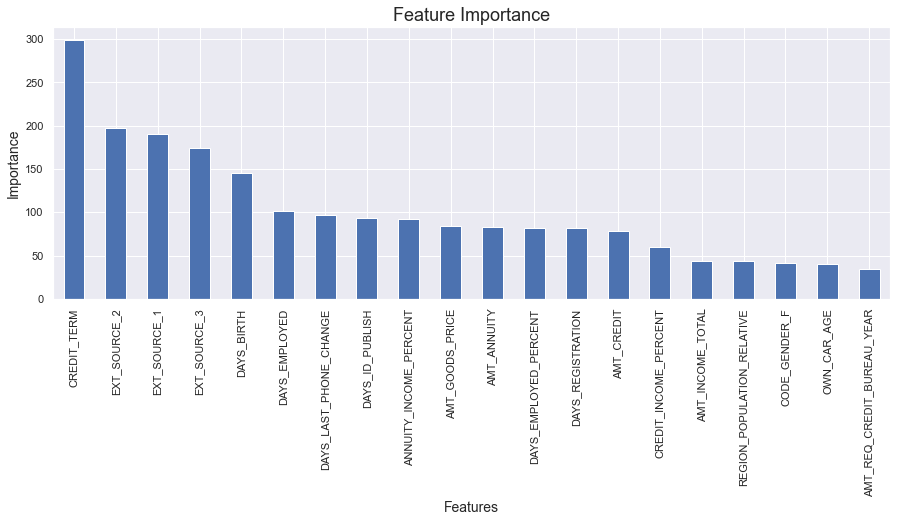

In [74]:
Importance = pd.DataFrame(model_lgbmc['lgbmclassifier'].feature_importances_, index = new_features, columns = ['Importance'])
plt.figure(figsize = (15,5))
Importance['Importance'].sort_values(ascending = False)[:20].plot.bar(y = 'Importance')
plt.title('Feature Importance', fontsize = 18)
plt.xlabel('Features', size = 14)
plt.ylabel('Importance', size = 14)
plt.show()

#### With Over Sampling

In [75]:
model_lgbmc = make_pipeline(preprocessor, SelectFromModel(XGBClassifier()), LGBMClassifier(random_state=42))

In [76]:
model_lgbmc.fit(X_train_ros, Y_train_ros)
pred_8 = model_lgbmc.predict_proba(X_test)
pred_8 = pred_8[:, 1]

[14:55:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [77]:
auc_8 = roc_auc_score(Y_test, pred_8)
print('AUC: ', auc_8)

AUC:  0.7663403587548185


In [78]:
pred_8_t = model_lgbmc.predict_proba(X_train_ros)
pred_8_t = pred_8_t[:, 1]
auc_8_t = roc_auc_score(Y_train_ros, pred_8_t)
print('AUC: ', auc_8_t)

AUC:  0.8033315981533014


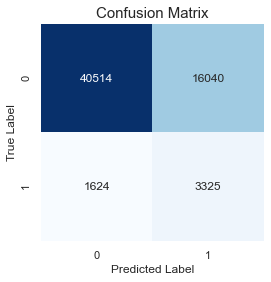

In [79]:
pred_test = model_lgbmc.predict(X_test)
conf_matrix(Y_test, pred_test)

In [80]:
precision_8 = precision_score(Y_test, pred_test)
recall_8 = recall_score(Y_test, pred_test)

print('precision: ', precision_8)
print('recall: ', recall_8)

precision:  0.17170152336689903
recall:  0.6718528995756718


In [81]:
mask = model_lgbmc['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(model_lgbmc['columntransformer'])):
    if bool:
        new_features.append(feature)

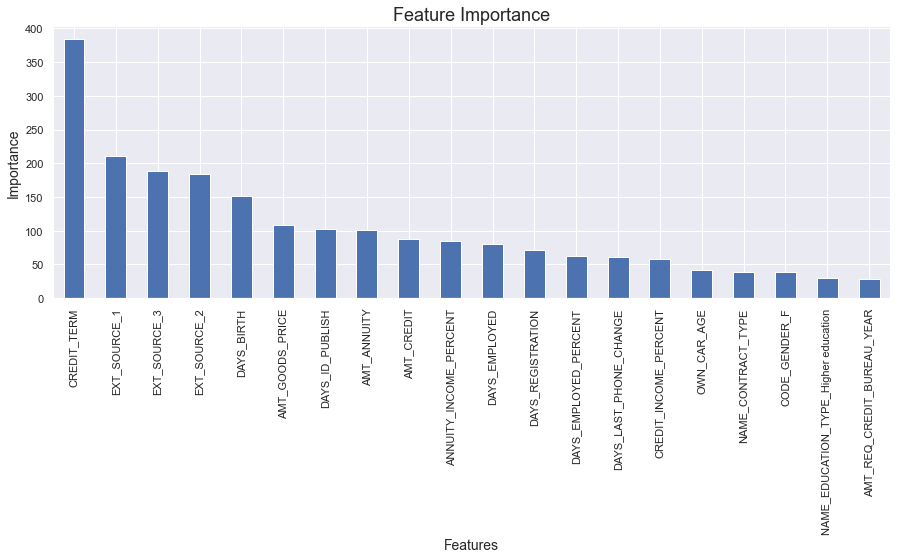

In [82]:
Importance = pd.DataFrame(model_lgbmc['lgbmclassifier'].feature_importances_, index = new_features, columns = ['Importance'])
plt.figure(figsize = (15,5))
Importance['Importance'].sort_values(ascending = False)[:20].plot.bar(y = 'Importance')
plt.title('Feature Importance', fontsize = 18)
plt.xlabel('Features', size = 14)
plt.ylabel('Importance', size = 14)
plt.show()

#### With SMOTE

In [83]:
model_lgbmc = make_pipeline(SelectFromModel(XGBClassifier()), LGBMClassifier(random_state=42))

In [84]:
X_train_smo_b = X_train_smo.copy()

In [85]:
X_train_smo_b = X_train_smo_b.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [86]:
model_lgbmc.fit(X_train_smo_b, Y_train_smo)
pred_9 = model_lgbmc.predict_proba(X_test_smo)
pred_9 = pred_9[:, 1]

[14:57:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [87]:
auc_9 = roc_auc_score(Y_test, pred_9)
print('AUC: ', auc_9)

AUC:  0.6623546559602218


In [88]:
pred_9_t = model_lgbmc.predict_proba(X_train_smo)
pred_9_t = pred_9_t[:, 1]
auc_9_t = roc_auc_score(Y_train_smo, pred_9_t)
print('AUC: ', auc_9_t)

AUC:  0.9784938681097959


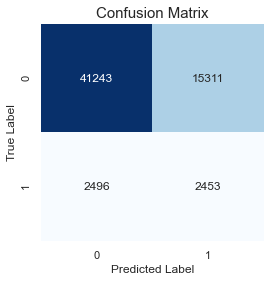

In [89]:
pred_test = model_lgbmc.predict(X_test_smo)
conf_matrix(Y_test, pred_test)

In [90]:
precision_9 = precision_score(Y_test, pred_test)
recall_9 = recall_score(Y_test, pred_test)

print('precision: ', precision_9)
print('recall: ', recall_9)

precision:  0.13808826840801622
recall:  0.49565568801778137


In [91]:
mask = model_lgbmc['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(preprocessor)):
    if bool:
        new_features.append(feature)

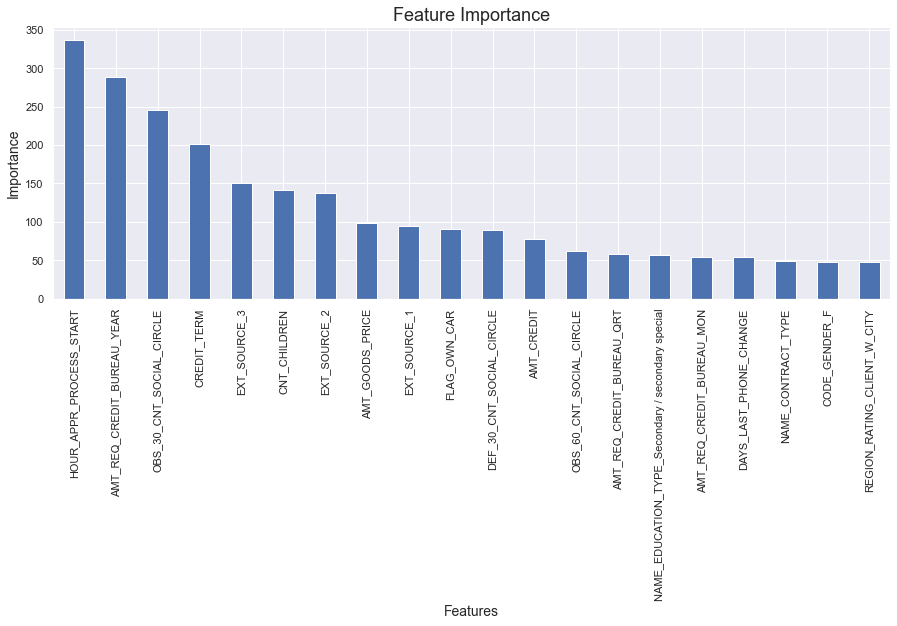

In [92]:
Importance = pd.DataFrame(model_lgbmc['lgbmclassifier'].feature_importances_, index=new_features, columns=['Importance'])
plt.figure(figsize=(15, 5))
Importance['Importance'].sort_values(ascending=False)[:20].plot.bar(y='Importance')
plt.title('Feature Importance', fontsize=18)
plt.xlabel('Features', size=14)
plt.ylabel('Importance', size=14)
plt.show()

### 3.4. XGBClassifier

#### With Under Sampling

In [93]:
model_xgbc = make_pipeline(preprocessor, SelectFromModel(XGBClassifier()), XGBClassifier(random_state=42))

In [94]:
model_xgbc.fit(X_train_rus, Y_train_rus)
pred_10 = model_xgbc.predict_proba(X_test)
pred_10 = pred_10[:, 1]

[14:59:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:59:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [95]:
auc_10 = roc_auc_score(Y_test, pred_10)
print('AUC: ', auc_10)

AUC:  0.7522457788900762


In [96]:
pred_10_t = model_xgbc.predict_proba(X_train_rus)
pred_10_t = pred_10_t[:, 1]
auc_10_t = roc_auc_score(Y_train_rus, pred_10_t)
print('AUC: ', auc_10_t)

AUC:  0.9065276167764389


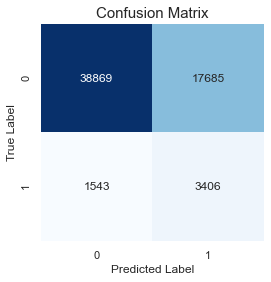

In [97]:
pred_test = model_xgbc.predict(X_test)
conf_matrix(Y_test, pred_test)

In [98]:
precision_10 = precision_score(Y_test, pred_test)
recall_10 = recall_score(Y_test, pred_test)

print('precision: ', precision_10)
print('recall: ', recall_10)

precision:  0.16149068322981366
recall:  0.6882198423924025


In [99]:
mask = model_xgbc['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(model_xgbc['columntransformer'])):
    if bool:
        new_features.append(feature)

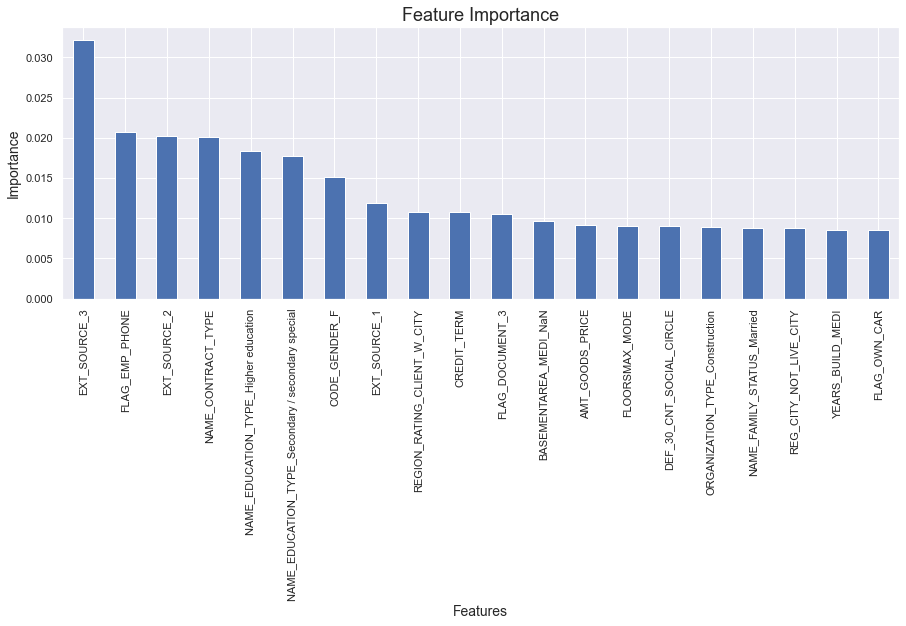

In [100]:
Importance = pd.DataFrame(model_xgbc['xgbclassifier'].feature_importances_, index = new_features, columns = ['Importance'])
plt.figure(figsize = (15,5))
Importance['Importance'].sort_values(ascending = False)[:20].plot.bar(y = 'Importance')
plt.title('Feature Importance', fontsize = 18)
plt.xlabel('Features', size = 14)
plt.ylabel('Importance', size = 14)
plt.show()

#### With Over Sampling

In [101]:
model_xgbc = make_pipeline(preprocessor, SelectFromModel(XGBClassifier()), XGBClassifier(random_state=42))

In [102]:
model_xgbc.fit(X_train_ros, Y_train_ros)
pred_11 = model_xgbc.predict_proba(X_test)
pred_11 = pred_11[:, 1]

[15:00:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:01:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [103]:
auc_11 = roc_auc_score(Y_test, pred_11)
print('AUC: ', auc_11)

AUC:  0.7576200933076456


In [104]:
pred_11_t = model_xgbc.predict_proba(X_train_ros)
pred_11_t = pred_11_t[:, 1]
auc_11_t = roc_auc_score(Y_train_ros, pred_11_t)
print('AUC: ', auc_11_t)

AUC:  0.8612874874554639


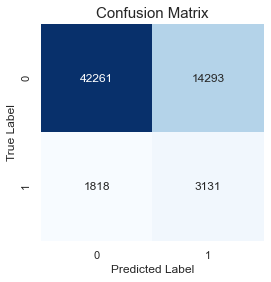

In [105]:
pred_test = model_xgbc.predict(X_test)
conf_matrix(Y_test, pred_test)

In [106]:
precision_11 = precision_score(Y_test, pred_test)
recall_11 = recall_score(Y_test, pred_test)

print('precision: ', precision_11)
print('recall: ', recall_11)

precision:  0.17969467401285583
recall:  0.6326530612244898


In [107]:
mask = model_xgbc['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(model_xgbc['columntransformer'])):
    if bool:
        new_features.append(feature)

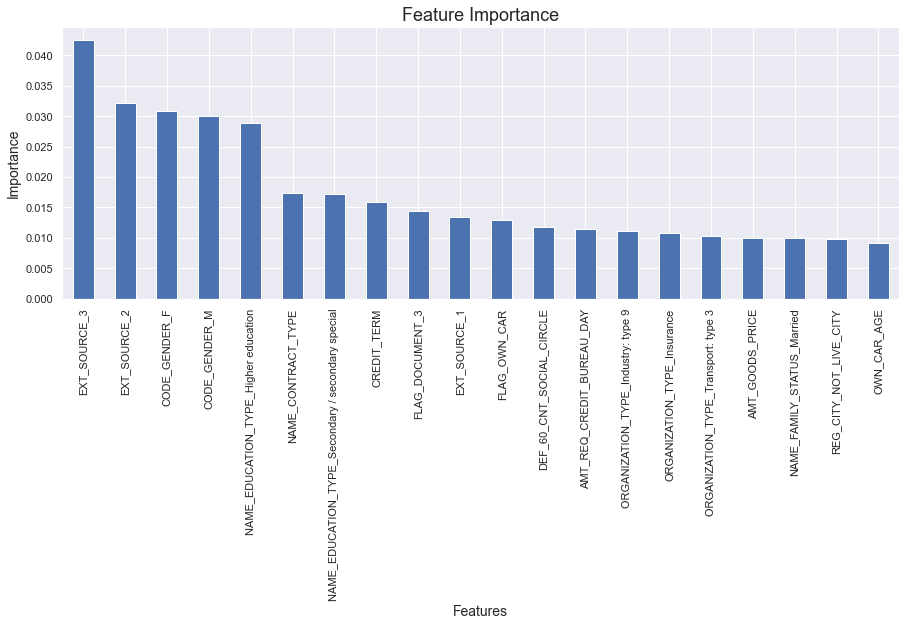

In [108]:
Importance = pd.DataFrame(model_xgbc['xgbclassifier'].feature_importances_, index = new_features, columns = ['Importance'])
plt.figure(figsize = (15,5))
Importance['Importance'].sort_values(ascending = False)[:20].plot.bar(y = 'Importance')
plt.title('Feature Importance', fontsize = 18)
plt.xlabel('Features', size = 14)
plt.ylabel('Importance', size = 14)
plt.show()

#### With SMOTE

In [109]:
model_xgbc = make_pipeline(SelectFromModel(XGBClassifier()), XGBClassifier(random_state=42))

In [110]:
model_xgbc.fit(X_train_smo, Y_train_smo)
pred_12 = model_xgbc.predict_proba(X_test_smo)
pred_12 = pred_12[:, 1]

[15:02:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:04:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [111]:
auc_12 = roc_auc_score(Y_test, pred_12)
print('AUC: ', auc_12)

AUC:  0.6279331477638022


In [112]:
pred_12_t = model_xgbc.predict_proba(X_train_smo)
pred_12_t = pred_12_t[:, 1]
auc_12_t = roc_auc_score(Y_train_smo, pred_12_t)
print('AUC: ', auc_12_t)

AUC:  0.9832073412911053


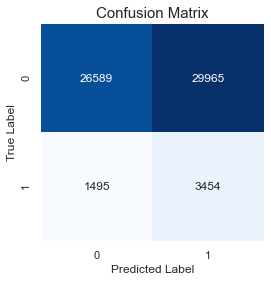

In [113]:
pred_test = model_xgbc.predict(X_test_smo)
conf_matrix(Y_test, pred_test)

In [114]:
precision_12 = precision_score(Y_test, pred_test)
recall_12 = recall_score(Y_test, pred_test)

print('precision: ', precision_12)
print('recall: ', recall_12)

precision:  0.10335437924533948
recall:  0.6979187714689836


In [115]:
mask = model_xgbc['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(preprocessor)):
    if bool:
        new_features.append(feature)

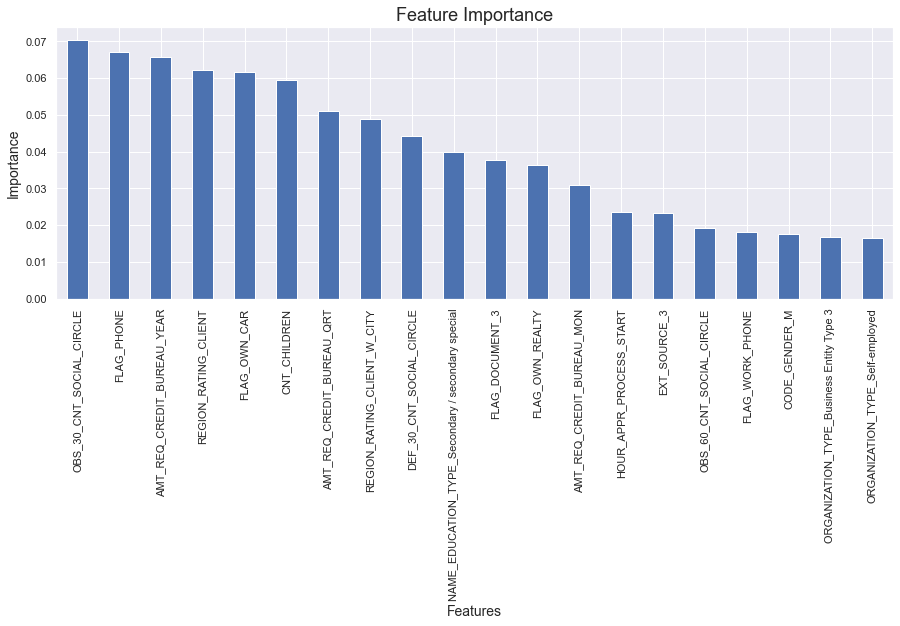

In [116]:
Importance = pd.DataFrame(model_xgbc['xgbclassifier'].feature_importances_, index = new_features, columns = ['Importance'])
plt.figure(figsize = (15,5))
Importance['Importance'].sort_values(ascending = False)[:20].plot.bar(y = 'Importance')
plt.title('Feature Importance', fontsize = 18)
plt.xlabel('Features', size = 14)
plt.ylabel('Importance', size = 14)
plt.show()

# 4. Results

In [117]:
model_name = ['Logistic Regression - RUS', 
              'Logistic Regression - ROS', 
              'Logistic Regression - SMOTE',
              'Random Forest Classifier - RUS',
              'Random Forest Classifier - ROS',
              'Random Forest Classifier - SMOTE',
              'LGBM Classifier - RUS',
              'LGBM Classifier - ROS',
              'LGBM Classifier - SMOTE',
              'XGB Classifier - RUS',
              'XGB Classifier - ROS',
              'XGB Classifier - SMOTE']

columns_name = ['AUC', 'AUC_Training', 'Precision', 'Recall']

df_result = pd.DataFrame(index = model_name, columns = columns_name)

In [118]:
count = 1
for i in model_name:
    df_result.loc[i, 'AUC'] = vars()['auc_' + str(count)]
    df_result.loc[i, 'AUC_Training'] = vars()['auc_' + str(count) + '_t']
    df_result.loc[i, 'Precision'] = vars()['precision_' + str(count)]
    df_result.loc[i, 'Recall'] = vars()['recall_' + str(count)]
    count = count + 1

In [119]:
df_result

,AUC,AUC_Training,Precision,Recall
Logistic Regression - RUS,0.749533,0.749424,0.159949,0.688826
Logistic Regression - ROS,0.749794,0.749887,0.159426,0.680744
Logistic Regression - SMOTE,0.729187,0.766751,0.147454,0.691655
Random Forest Classifier - RUS,0.736622,1,0.16023,0.652253
Random Forest Classifier - ROS,0.732446,1,0.429864,0.0191958
Random Forest Classifier - SMOTE,0.679978,1,0.186306,0.19903
LGBM Classifier - RUS,0.762209,0.823593,0.165633,0.691049
LGBM Classifier - ROS,0.76634,0.803332,0.171702,0.671853
LGBM Classifier - SMOTE,0.662355,0.978494,0.138088,0.495656
XGB Classifier - RUS,0.752246,0.906528,0.161491,0.68822
